<h1><center><font size="6">Default of Credit Card Clients - Predictive Models</font></center></h1>



# Contents

- Introduction  
- Load packages 
- Read the data
- Check the data 
    - Glimpse the data
    - Check missing data
    - Check data imbalance
- Data exploration
- Predictive models
    - RandomForrestClassifier
    - AdaBoostClassifier
    - CatBoostClassifier
    - XGBoost
    - LightGBM
- Conclusions
- References


# Introduction


## Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from **April 2005** to **September 2005**. 

## Content

There are 25 variables:

* **ID**: ID of each client
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* **PAY_2**: Repayment status in August, 2005 (scale same as above)
* **PAY_3**: Repayment status in July, 2005 (scale same as above)
* **PAY_4**: Repayment status in June, 2005 (scale same as above)
* **PAY_5**: Repayment status in May, 2005 (scale same as above)
* **PAY_6**: Repayment status in April, 2005 (scale same as above)
* **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)
* **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)
* **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)
* **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)
* **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)
* **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)
* **PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)
* **PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)
* **PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)
* **PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)
* **PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)
* **PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)
* **default.payment.next.month**: Default payment (1=yes, 0=no)

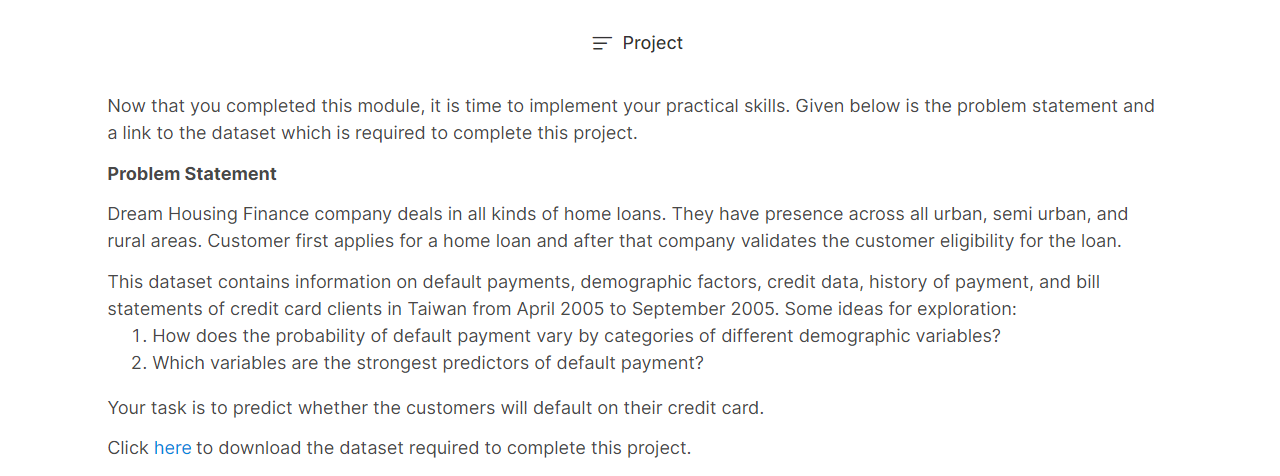

# Load packages


In [0]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Read the data

In [0]:
# header 1 ensures that row at index 1 is used as column name header
data = pd.read_excel('default of credit card clients.xls', header = 1)

# Check the data

In [0]:
print("Default Credit Card Clients data -  rows:",data.shape[0]," columns:", data.shape[1])

## Glimpse the data

We start by looking to the data features (first 5 rows).

In [0]:
data.head()

Let's look into more details to the data.

In [0]:
data.describe()

* There are 30,000 distinct credit card clients.  

* The average value for the amount of credit card limit is 167,484. The standard deviation is unusually large, max value being 1M.

* Education level is mostly graduate school and university.

* Most of the clients are either marrined or single (less frequent the other status).

* Average age is 35.5 years, with a standard deviation of 9.2.

* As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).


## Check missing data

Let's check if there is any missing data.

In [0]:
# total missing data
total = data.isnull().sum().sort_values(ascending = False)

# missing data interms of percentage with respect to complete data
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)

# printing information in dataframe format
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

* There is no missing data in the entire dataset.

## Data imbalance

Let's check data imbalance with respect with *target* value, i.e. **default payment next month**.

In [0]:
# calculating value counts in the target variable and storing in dataframe
temp = data["default payment next month"].value_counts(normalize=True)
df = pd.DataFrame({'default payment next month': temp.index,'values': temp.values})

# plotting
plt.figure(dpi = 140)
plt.title('Checking data imbalance \n (Default = 0, Not Default = 1)')
plt.bar(df['default payment next month'], df['values'])
plt.show()

A number of **6,636** out of **30,000** (or **22%**) of clients will default next month. The data has not a large unbalance with respect of the target value (default.payment.next.month).

# Data exploration

## Amount of credit limit 

In [0]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

Largest group of amount of credit limit is apparently for amount of 50K. Let's verify this.

In [0]:
data['LIMIT_BAL'].value_counts().shape

There are 81 distinct values for amount of credit limit.

In [0]:
data['LIMIT_BAL'].value_counts().head(5)

Indeed, the largest number of credit cards are with limit of 50,000 (3365), followed by 20,000 (1976) and 30,000 (1610).

## Amount of credit limit grouped by default payment next month

Let's visualize the density plot for amount of credit limit (LIMIT_BAL), grouped by default payment next month.

In [0]:
class_0 = data.loc[data['default payment next month'] == 0]["LIMIT_BAL"]
class_1 = data.loc[data['default payment next month'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

Most of defaults are for credit limits 0-100,000 (and density for this interval is larger for defaults than for non-defaults). Larger defaults number are for the amounts of **50,000**, **20,000** and **30,000**.

## Credit limit vs. sex

Let's check the credit limit distribution vs. sex. For the sex, 1 stands for male and 2 for female.

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=data, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=data, palette="PRGn",showfliers=False)
plt.show();

The limit credit amount is quite balanced between sexes. The males have a slightly smaller Q2 and larger Q3 and Q4 and a lower mean. The female have a larger outlier max value (1M NT dollars).

## Features correlation


For the numeric values, let's represent the features correlation.


Let's check the correlation of Amount of bill statement in April - September 2005.

In [0]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


Let's check the correlation of Amount of previous payment in April - September 2005.

In [0]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

There are no correlations between amounts of previous payments for April-Sept 2005.

Let's check the correlation between Repayment status in April - September 2005.

In [0]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize = (8,8))
plt.title('Repayment status (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


## Sex, Education, Age and Marriage


Let's show sex, education, age and marriage distributions.

We start by showing the boxplots with age distribution grouped by marriage status and sex.

Marriage status meaning is:

* 0 : unknown (let's consider as others as well)
* 1 : married
* 2 : single
* 3 : others

Sex meaning is:

* 1 : male
* 2 : female


In [0]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

In [0]:
boxplot_variation('MARRIAGE','AGE', 'SEX',8)

It looks like Married status 3 (others), with mean values over 40 and Q4 values over 60 means mostly vidowed or divorced whilst Married status 0 could be not specified or divorced, as Q1 values are above values for married of both sexes.

Married males have mean age above married women. Unmarried males have mean value for age above unmarried women as well but closer. Q3 abd Q4 values for married man are above corresponding values for married women.


Let's show the boxplots with age distribution grouped by education and marriage.

Education status meaning is:

* 1 : graduate school
* 2 : university
* 3 : high school
* 4 : others
* 5 : unknown
* 6 : unknow


In [0]:
boxplot_variation('EDUCATION','AGE', 'MARRIAGE',12)

## Age, sex and credit amount limit


Let's show the  boxplots with credit amount limit distribution grouped by age and sex.



In [0]:
boxplot_variation('AGE','LIMIT_BAL', 'SEX',16)

Mean, Q3 and Q4 values are increasing for both male and female with age until aroung 35 years and then they are oscilating and get to a maximum of Q4 for males at age 64.

Mean values are generally smaller for males than for females, with few exceptions, for example at age 39, 48, until approximately 60, where mean values for males are generally larger than for females.



## Marriage status, education level and credit amount limit


Let's show the  boxplots with credit amount limit distribution grouped by marriage status and education level.

In [0]:
boxplot_variation('MARRIAGE','LIMIT_BAL', 'EDUCATION',12)

# Predictive models



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [0]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

### Split data in train and validation set

Let's define train and validation sets.

In [0]:
train_df, val_df = train_test_split(data, test_size=0.25, random_state=42, shuffle=True )

We also make copies of the train_df and val_df for later usage.

In [0]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

## RandomForestClassifier




Let's run a model using the training set for training. Then, we will use the validation set for validation. 

### Metric

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** .  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [0]:
clf = RandomForestClassifier(n_jobs=-1, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=350,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [0]:
predictors = train_df.drop(columns=['default payment next month']).columns.values
target = 'default payment next month'

In [0]:
clf.fit(train_df[predictors].values, train_df[target].values)

Let's now predict the **target** values for the **val_df** data, using **predict** function.

In [0]:
preds = clf.predict(val_df[predictors])

Let's also visualize the features importance.

### Features importance

In [0]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


The most important features are **PAY_0**, **AGE**, **BILL_AMT1**, **LIMIT_BAL**, **BILL_AMT2**, **BILL_AMT3**.


### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

In [0]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

We also calculate area under curve (receiver operator characteristic).

In [0]:
roc_auc_score(val_df[target].values, preds)

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.66**.


Let's use for RandomForrestClassifier **dummified variables** for the **categorical features**.


We start by defining the categorical features.


### RandomForrest with OneHotEncoder

In [0]:
cat_features = ['EDUCATION', 'SEX', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [0]:
train_f_df = pd.get_dummies(train_df_bkp, columns = cat_features)
val_f_df = pd.get_dummies(val_df_bkp, columns = cat_features)

In [0]:
print("Default of Credit Card Clients train data -  rows:",train_f_df.shape[0]," columns:", train_f_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_f_df.shape[0]," columns:", val_f_df.shape[1])

Because train and validation data does not have the same number of columns, we will align them.

In [0]:
train_fa_df, val_fa_df = train_f_df.align(val_f_df, join='outer', axis=1, fill_value=0)

Let's check again the data.

In [0]:
print("Default of Credit Card Clients train data -  rows:",train_fa_df.shape[0]," columns:", train_fa_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_fa_df.shape[0]," columns:", val_fa_df.shape[1])

In [0]:
train_fa_df.head(5)

In [0]:
val_fa_df.head(5)

Let's define the target and predictors lists.

In [0]:
target_f = 'default payment next month'
predictors_f = ['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_-2', 'PAY_0_0',
       'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6',
       'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0', 'PAY_2_1',
       'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7',
       'PAY_2_8', 'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3',
       'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1',
       'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5',
       'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_-2', 'PAY_6_0',
       'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7',
       'PAY_6_8', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2']

Let's train the **RandonForestClassifier** using the **train_fa_df** data and **fit** function.

In [0]:
clf.fit(train_fa_df[predictors_f], train_df[target_f].values)

Let's now predict the **target** values for the **val_df** data, using **predict** function.

In [0]:
preds = clf.predict(val_fa_df[predictors_f])

Let's also visualize the features importance. 

#### Features importance

In [0]:
tmp = pd.DataFrame({'Feature': predictors_f, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are **AGE**, **LIMIT_BAL**, **BILL_AMT1**, **PAY_0_2**, **BILL_AMT2**, **BILL_AMT3**.

#### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

In [0]:
cm = pd.crosstab(val_fa_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

We also calculate area under curve (receiver operator characteristic)

In [0]:
roc_auc_score(val_fa_df[target].values, preds)

With the dummified features, the improvement of the AUC score is quite small.

In [0]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced 
         }

# Conclusions

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features.   

We Concluded with **RandomForrestClassifier**, for which we obtained an AUC scode of **0.65**. 